# Seq2seq Translation
## Translation with an RNN
Seq2seq can be more challenging than classification, since output is of variable length (and typically different length from input). 

In pure PyTorch, translations is much harder. 

[data original website](http://www.statmt.org/wmt15/translation-task.html)

In [1]:
from fastai.text.all import *
path = Config.config_path
path

Path('/home/fastai2/.fastai')

In [2]:
# !wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}
# !tar xf {path}/giga-fren.tgz -C {path}

In [3]:
path = path/"giga-fren"
path.ls()

(#5) [Path('/home/fastai2/.fastai/giga-fren/giga-fren.release2.fixed.en'),Path('/home/fastai2/.fastai/giga-fren/questions_easy.csv'),Path('/home/fastai2/.fastai/giga-fren/cc.fr.300.bin'),Path('/home/fastai2/.fastai/giga-fren/cc.en.300.bin'),Path('/home/fastai2/.fastai/giga-fren/giga-fren.release2.fixed.fr')]

If we are going to train only on questions: these are the lines to be run once only. 

In [4]:
# with open(path/"giga-fren.release2.fixed.fr") as f: fr = f.read().split("\n")
# with open(path/"giga-fren.release2.fixed.en") as f: en = f.read().split("\n")

# re_eq = re.compile("^(Wh[^?.!]+\?)")
# re_fq = re.compile("^([^?.!]+\?)")
# en_fname = path/"giga-fren.release2.fixed.en"
# fr_fname = path/"giga-fren.release2.fixed.fr"

# lines = ((re_eq.search(eq), re_fq.search(fq))
#         for eq, fq in zip(open(en_fname, encoding="utf-8"),
#                           open(fr_fname, encoding="utf-8")))

# qs = [(e.group(), f.group()) for e, f, in lines if e and f]
# qs = [(q1, q2) for q1, q2 in qs]

# df = pd.DataFrame({"fr": [q[1] for q in qs], "en": [q[0] for q in qs]}, 
#         columns=["en", "fr"])
# df.to_csv(path/"questions_easy.csv", index=False)

In [5]:
path.ls()

(#5) [Path('/home/fastai2/.fastai/giga-fren/giga-fren.release2.fixed.en'),Path('/home/fastai2/.fastai/giga-fren/questions_easy.csv'),Path('/home/fastai2/.fastai/giga-fren/cc.fr.300.bin'),Path('/home/fastai2/.fastai/giga-fren/cc.en.300.bin'),Path('/home/fastai2/.fastai/giga-fren/giga-fren.release2.fixed.fr')]

## Load data into DataBunch

In [6]:
df = pd.read_csv(path/"questions_easy.csv")
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,"What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?","Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?"


In [7]:
df["en"] = df["en"].apply(lambda x: x.lower())
df["fr"] = df["fr"].apply(lambda x: x.lower())

We want to collate inputs and targets in a batch: they have different lengths so we need to add padding to make sequence length the same. 

In [8]:
dls = DataBlock(
    blocks=(TextBlock.from_df("fr", tok=SpacyTokenizer("fr")), TextBlock.from_df("en")),
    get_x=ColReader("text"), get_y=ColReader("text"), 
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=64, num_workers=os.cpu_count(), seq_len=30)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [9]:
dls.show_batch(max_n=2)

,text,text_
0,"xxbos dans un tel cas , où il s’ agit d ’ apprécier si un nom commercial a un fondement juridique antérieur à celui d ’ une marque aux fins de l’ article 16 , paragraphe 1 , troisième phrase , de l’ accord adpic , peut -on considérer comme décisif : i ) le fait que , dans l’ état où la marque est enregistrée et sa protection réclamée , le nom commercial ait été , du moins dans une certaine mesure , connu dans les milieux professionnels xxunk xxunk de l’ état concerné avant la date à laquelle l’ enregistrement de la marque y a été demandé ; ou que , dans les relations commerciales intéressant l’ état où la marque est xxunk ée et sa protection réclamée , le nom commercial ait été utilisé avant la date à laquelle l’ enregistrement de la marque a été demandé","xxbos when assessing , in such a case , whether a trade name has a legal basis prior to a trade mark for the purposes of the third sentence of article 16(1 ) of the trips agreement , may it thus be considered as decisive : ( i ) whether the trade name was well known at least to some extent among the relevant trade circles in the state in which the trade mark is registered and in which protection is sought for it , before the point in time at which registration of the trade mark was applied for in the state in question ; or whether the trade name was used in commerce directed to the state in which the trade mark is registered and in which protection is sought for it , before the point in time at which registration of the trade mark was applied for in the state in question ; or what other factor may decide whether the trade name is to be regarded as an existing prior right within the meaning of the third sentence of article 16(1 ) of the trips agreement ?"
1,"xxbos en xxunk que « les etats membres prennent les mesures nécessaires pour interdire le xxunk des travailleuses ( … ) ( enceintes , xxunk ou xxunk ) pendant la période allant du début de leur grossesse jusqu’ au terme du congé de maternité ( … ) , sauf dans les cas d’ exception non liés à leur état » , l’ article 10 de la directive oblige -t -il les etats membres à préciser de manière spéciale et exceptionnelle quelle peuvent être les causes de xxunk d’ une travailleuse enceinte , xxunk ou xxunk et à introduire à cet effet dans la législation nationale , parallèlement au régime général de xxunk des contrats de travail , un autre régime , spécial , exceptionnel , plus limité et xxunk pour les cas dans lesquels la travailleuse est enceinte , xxunk ou xxunk ?","xxbos where article 10 of the directive states that the dismissal of a worker who is pregnant , has given birth or is breast - feeding is to take place "" where applicable , provided that the competent require that a worker who is pregnant , has given birth or is breast - feeding may be dismissed only by means of a special procedure in which the appropriate competent authority gives its consent prior to the dismissal which the employer seeks ?"


In [10]:
import fasttext as ft 

Download word vectors

In [11]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

# !gunzip {path} / cc.en.300.bin.gz
# !gunzip {path} / cc.fr.300.bin.gz

In [12]:
import fasttext.util
# fasttext.util.download_model("en", if_exists="ignore")
# en_vecs = ft.load_model("cc.en.300.bin")

# fasttext.util.download_model("fr", if_exists="ignore")
# fr_vecs = ft.load_model("cc.fr.300.bin")

In [13]:
fr_vecs = ft.load_model(str((path/"cc.fr.300.bin")))
en_vecs = ft.load_model(str((path/"cc.en.300.bin")))

Create embedding module with pretrained vectors and random data for missing parts. 

In [14]:
from tqdm.auto import tqdm


def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w: vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i, w in enumerate(tqdm(itos)):
        try: wgts[i] = tensor(vec_dic[w])
        except Exception: miss.append(w)
    return emb

In [ ]:
dls.vocab[0][-5:]

In [15]:
from utils import *
emb_enc = create_emb(fr_vecs, dls.vocab[0])  # don't need int to str. It's already str. 
emb_dec = create_emb(en_vecs, dls.vocab[1])
emb_enc.weight.size(), emb_dec.weight.size()

  0%|          | 0/11600 [00:00<?, ?it/s]

  0%|          | 0/9112 [00:00<?, ?it/s]

(torch.Size([11600, 300]), torch.Size([9112, 300]))

In [16]:
model_path = Config.config_path/"models"

torch.save(emb_enc, model_path/"fr_emb.pth")
torch.save(emb_dec, model_path/"en_emb.pth")

## Our Model
Encoder is RNN, feed in input sentence, producing an output (that we discard for now) and hidden state. **Hidden state** is the activations that come out of an RNN. 

Hidden state is given to decoder (another RNN) using in conjunction with outputs it predicts to produce translation. We loop until decoder produces a padding token (or at least 30 iterations to make sure it's not infinite loop at beginning of training).

We use GRU for encoder and separate GRU for decoder. Other options are LSTMs or QRNNs. 

In [17]:
class Seq2SeqRNN(Module):
    def __init__(self, emb_enc, emb_dec, nh, 
                out_sl, nl=2, bos_idx=0, pad_idx=1):
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.em_sz_enc = emb_enc.embedding_dim 
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings

        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl, 
                    dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)

        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                    dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data

    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h

    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:, 0]))
        return h, outp

    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx

        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp == self.pad_idx).all(): break

        return torch.stack(res, dim=1)

    def initHidden(self, bs): 
        return one_param(self).new_zeros(self.nl, bs, self.nh)

The 1st size is not the sequence length anymore. Instead, it's the sentence length. It might vary depends on what your first sentence is. **This is my guesses. Check if it is correct.**

In [18]:
xb, yb = next(iter(dls.valid))
xb.shape

torch.Size([64, 131])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30).to(device)
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(11600, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(9112, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=9112, bias=True)
)

In [20]:
len(xb[0])

131

In [21]:
h = rnn.encoder(64, xb.to(device))
h.size()

torch.Size([2, 64, 300])

The loss pads output and target so they are of the same size before using the usual flattened version of cross entropy. We do the same for accuracy. 

In [22]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len - out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len - targ_len, 0, 0), value=pad_idx)
    return CrossEntropyLossFlat()(out, targ)

### Train our model

The accuracy supposed to be defined in the next section, but we are to include it in the training metrics, so let's write it out first before continuing. 

In [23]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len - out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len - targ_len, 0, 0), value=pad_idx)
    out = out.argmax(2)
    return (out == targ).float().mean()

SuggestedLRs(valley=tensor(0.0003))

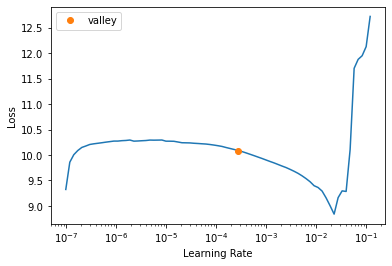

In [24]:
torch.cuda.empty_cache()
learn = Learner(dls, rnn.cuda(), loss_func=seq2seq_loss)
learn.lr_find()

In [25]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,time
0,6.562098,8.108996,01:11
1,6.505287,7.040142,01:08
2,6.194099,6.553522,01:10
3,6.000668,5.502668,01:09


In [26]:
# learnt = Learner(dls, rnn.cuda(), loss_func=seq2seq_loss, metrics=seq2seq_acc)
# learnt.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,time
0,6.039598,5.617062,0.288137,01:12


In [27]:
# We can free up some RAM (although on this instance one rented it has 56GB of 
# RAM, sufficient to just keep it if required)
del fr_vecs
del en_vecs

import gc
gc.collect()

11364

We can use BLEU metric
### BLEU 


In [28]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram, self.max_n = ngram, max_n
    def __eq__(self, other): 
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_i**i for i, o in enumerate(self.ngram)]))

In [29]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i: i + n], max_n=max_n) for i in range(len(x) - n + 1)]

In [30]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g, c in pred_cnt.items()]), len(pred_grams)

In [31]:
# class CorpusBLEU(Callback):
#     def __init__(self, vocab_sz): 
#         self.vocab_sz = vocab_sz
#         self.name = "bleu"

#     def on_epoch_begin(self, **kwargs):
#         self.pred_len, self.targ_len, self.corrects, self.counts = 0, 0, [0] * 4, [0] * 4

#     def on_batch_end(self, last_output, last_target, **kwargs):
#         last_output = last_output.argmax(dim=-1)
        
#         for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
#             self.pred_len += len(pred)
#             self.targ_len += len(targ)

#             for i in range(4):
#                 c, t = get_correct_ngrams(pred, targ, i + 1, max_n=self.vocab_sz)
#                 self.corrects[i] += c
#                 self.counts[i] += t

#     def on_epoch_end(self, last_metrics, **kwargs):
#         precs = [c / t for c, t in zip(self.corrects, self.counts)]
#         len_penalty = np.exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
#         bleu = len_penalty * ((precs[0] * precs[1] * precs[2] * precs[3]) ** 0.25)
#         return add_metrics(last_metrics, bleu)

For fastai v2, we already have `CorpusBLEUMetric` included. Plus `add_metrics` isn't available anymore (at least, it might be a different name, see [here](https://forums.fast.ai/t/equivalent-of-add-metrics-in-fastai2/77575/2) for a replacement). So, we will just use the internal metrics. 

SuggestedLRs(valley=tensor(0.0025))

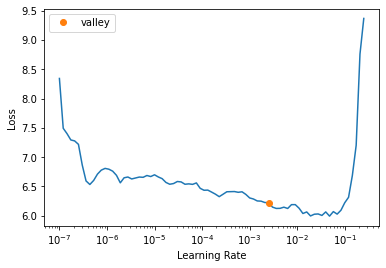

In [32]:
learn = Learner(dls, rnn.cuda(), loss_func=seq2seq_loss, 
        metrics=[seq2seq_acc, CorpusBLEUMetric(len(dls.vocab[1]))])
learn.lr_find()

In [33]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,corpus_bleu,time
0,5.411106,6.927032,0.190018,0.158424,01:21
1,5.852787,4.201866,0.442469,0.272785,01:30
2,6.211847,4.701537,0.394371,0.266400,01:25
3,6.090792,5.671773,0.274415,0.225707,01:19


In [34]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,corpus_bleu,time
0,6.032113,5.258982,0.319726,0.257719,01:20
1,5.900082,5.039589,0.337413,0.244741,01:19
2,5.875796,5.254868,0.315593,0.244840,01:20
3,5.798594,5.327102,0.306154,0.237269,01:19


Let's see a few predictions to see how good our model is. 

In [35]:
# `get_predictions` is integrated within learner. 
inputs, preds, targs = learn.get_preds(with_input=True)

In [36]:
preds[0].shape

torch.Size([9, 9112])

Seems like our output size is wrong... 

In [37]:
inputs[0].shape

torch.Size([67])

Notice we have a different shape here. If you try to pass a prediction to `learn.model(xb)` (just like in the original code), you got a shape that looks like `torch.Size([17, 24, 9112])` for example (the first digit will change, the second digit might change). Just like in the original example, `get_preds` takes the `argmax(1)`, leaving you with `torch.size([17, 9112])`. Now however, you want to take **one more argmax** because we want to know which vocab is being activated. So instead of passing `preds[0]` to `itos`, we will pass in `preds[0].argmax(1)`. 

Another noting from above is that, wouldn't that means our final length of `preds[0].argmax(1)` be shorter than both `inputs` and `targs`? Yes, that is of course! Because either the inputs or targs (depending on which one is longer) have paddings. So we would expect the original `targs` (for this index 0, in my case) to be a shorter sentence plus few paddings at the end. So this shorter is expected. 

In [38]:
inputs[700]

TensorText([   2,   40,   17,   44,   19,   13,  752,   29,  610,   15,  998,   14,
        1435,  982,   25,   61,   63, 3609,   55,    9,    1,    1,    1,    1,
           1,    1])

In [39]:
def get_predictions(num, inputs=inputs, preds=preds, targs=targs): 
    return (
        itos(dls.vocab[0], inputs[num], join=True, ignore_pad=True),
        itos(dls.vocab[1], targs[num], join=True, ignore_pad=True),
        itos(dls.vocab[1], preds[num].argmax(1), join=True)
    )

In [40]:
get_predictions(700)

("xxbos qu' est -ce que le centre d' analyse des opérations et déclarations financières du canada ( canafe ) ?",
 'xxbos what is fintrac ?',
 'xxbos what is the mean and and and and xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad')

In [41]:
get_predictions(701)

("xxbos qu' en est -il des contenus d' enseignement non directement religieux , mais qui comportent des modèles de comportements que certains citoyens xxunk au nom de leurs convictions religieuses ?",
 'xxbos what happens to the content of teaching that is not directly religious but includes behavioural models that some citizens condemn due to their religious beliefs ?',
 'xxbos what is the the to to to to to , , , , xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad')

In [42]:
get_predictions(2513)

("xxbos qui , dans la mer de l' information et dans les voix de la concurrence , doit être représenté et pourquoi ?",
 'xxbos who in the great sea of information and competing voices should be represented , and why ?',
 'xxbos who should the be to to to to to the and and and and and and and and and and and and and and and and and and and')

In [43]:
get_predictions(4000)

('xxbos si le bénéficiaire n’ est toujours pas intéressé , quel est l’ intérêt ?',
 'xxbos what ’s the point if the xxunk still go unanswered ?',
 'xxbos what is the the of the the the xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad')

## Teacher Forcing
Feeding decoder real targets instead of predictions (if it starts with wrong words, it's very unlikely to give us the right translation). We do all time at beginning, and gradually reducing amount of teacher forcing. 

One doesn't know how to implement teacher forcing for fastai v2. However, it seems that in the forums, people already implemented it. So let's take it here. [Check its source](https://forums.fast.ai/t/timeseries/55861/102) and [here](https://forums.fast.ai/t/basic-seq2seq-teacher-forcing-troubles/85917/8)

In [44]:
class TeacherForcing(Callback):
    def __init__(self, end_epoch): self.end_epoch = end_epoch
    
    def before_batch(self): 
        self.learn.xb = (self.x, self.y)

    def before_epoch(self):
        self.learn.model.pr_force = 1 - self.learn.epoch / self.end_epoch

In [45]:
class Seq2SeqRNN_tf(Module):
    def __init__(self, emb_enc, emb_dec, nh, 
                out_sl, nl=2, bos_idx=0, pad_idx=1):
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.em_sz_enc = emb_enc.embedding_dim 
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings

        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl, 
                    dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)

        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                    dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.

    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h

    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:, 0]))
        return h, outp

    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx

        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp == self.pad_idx).all(): break
            
            if (targ is not None) and (random.random() < self.pr_force):
                if i >= targ.shape[1]: continue
                dec_inp = targ[:, i]

        return torch.stack(res, dim=1)

    def initHidden(self, bs): 
        return one_param(self).new_zeros(self.nl, bs, self.nh)

In [46]:
emb_enc = torch.load(model_path/"fr_emb.pth")
emb_dec = torch.load(model_path/"en_emb.pth")

SuggestedLRs(valley=tensor(0.0006))

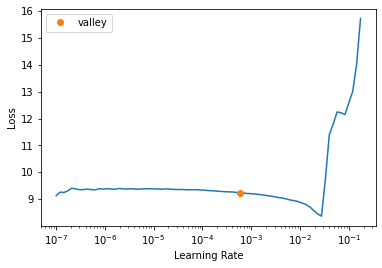

In [47]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 30).to(device)

torch.cuda.empty_cache()
learn = Learner(dls, rnn_tf, loss_func=seq2seq_loss, 
                metrics=[seq2seq_acc, CorpusBLEUMetric(len(dls.vocab[1]))],
                cbs=[TeacherForcing(6)])
learn.lr_find()

In [48]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,corpus_bleu,time
0,3.390180,3.198703,0.551186,0.372622,02:00
1,3.137193,3.455440,0.522183,0.335396,01:43
2,3.486295,3.609107,0.502148,0.315785,01:39
3,3.577449,3.408627,0.513732,0.342165,01:35
4,4.114766,4.361354,0.401254,0.263876,01:30
5,4.215417,4.654742,0.355950,0.237092,01:26
6,4.789557,4.902882,0.321629,0.213042,01:23
7,4.285396,4.676368,0.344412,0.228472,01:25
8,4.045466,4.486600,0.365141,0.243410,01:27
9,3.665760,4.481407,0.365789,0.242955,01:28


One is unsure what's the problem with teacher forcing. Perhaps there are some problems with the original callback function, or it is a problem with the training itself. One doesn't know for sure. 

In [49]:
inputs, preds, targs = learn.get_preds(with_input=True)

In [50]:
get_predictions(700, inputs, preds, targs)

("xxbos qu' est -ce que le centre d' analyse des opérations et déclarations financières du canada ( canafe ) ?",
 'xxbos what is fintrac ?',
 'xxbos what is the mean and and and and xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad')

In [51]:
get_predictions(2513, inputs, preds, targs)

("xxbos qui , dans la mer de l' information et dans les voix de la concurrence , doit être représenté et pourquoi ?",
 'xxbos who in the great sea of information and competing voices should be represented , and why ?',
 'xxbos who should the be to to to to to the and and and and and and and and and and and and and and and and and and and')

In [52]:
get_predictions(4000, inputs, preds, targs)

('xxbos si le bénéficiaire n’ est toujours pas intéressé , quel est l’ intérêt ?',
 'xxbos what ’s the point if the xxunk still go unanswered ?',
 'xxbos what is the the of the the the xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad')

# Breakpoint

In [1]:
from fastai.text.all import *
from utils import *

path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/"texts.csv")

imdb_clas = DataBlock(
    blocks=(TextBlock.from_df("text", seq_len=72), CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("label"), splitter=ColSplitter()
)

dls = imdb_clas.dataloaders(df, bs=32)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [2]:
m = np.array([3, 5, 35, 42, 73, 81, 99, 102])  # random list
baseline = np.array([dls.vocab[0][a] for a in m])
baseline

array(['xxeos', 'xxrep', 'on', 'have', 'she', 'only', 'also', 'people'],
      dtype='<U6')

In [4]:
stoi(dls.vocab[0], np.array(["what", "is", "this", "thing"]))

array([ 64,  16,  21, 173], dtype=uint8)

In [5]:
dls.vocab[0][64]

'what'

In [7]:
str_list_to_par(dls, 0)

"xxbos xxmaj un - bleeping - believable ! xxmaj meg xxmaj ryan does n't even look her usual pert lovable self in this , which normally makes me forgive her shallow ticky acting schtick . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj whoosh … xxmaj banzai xxrep 3 ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj chill ? xxmaj must be a replay of xxmaj jonestown - hollywood style . w xxrep 3 o xxrep 3 f !"